<a href="https://colab.research.google.com/github/KeuleUngaBunga/WP_DIFF_KI/blob/Tjark/Aufgabe2_DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepinv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.6/807.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.2 MB/s eta 0:00:00


In [2]:
import torch
if torch.cuda.is_available():
    print("GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU instead.")

GPU is available.
GPU Name: Tesla T4


In [3]:
import deepinv
from torchvision import datasets, transforms
import torch


device = "cuda"
batch_size = 32
image_size = 32

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.Grayscale(num_output_channels=1), # Convert to 1 channel
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

lr = 1e-4
epochs = 1

model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained=None).to(
  device
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = deepinv.loss.MSE()

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

for epoch in range(epochs):
    print(f"epoch:{epoch}")
    model.train()
    i=0
    for data, _ in train_loader:
        i=i+1
        # print(i) # Removed excessive print for cleaner output
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()
        estimated_noise = model(noised_imgs, t, type_t="timestep")
        loss = mse(estimated_noise, noise)
        loss.mean().backward() # Added .mean() to ensure scalar loss
        optimizer.step()

torch.save(
    model.state_dict(),
    "trained_diffusion_model.pth",
)


100%|██████████| 170M/170M [00:04<00:00, 41.7MB/s]


epoch:0


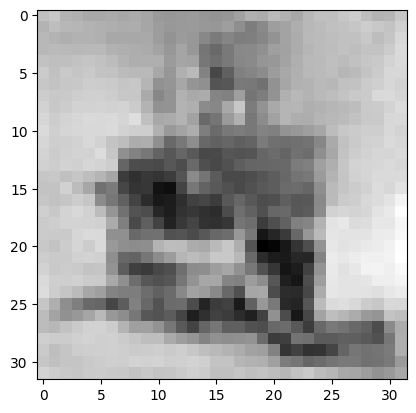

In [9]:
import torch
import deepinv
from pathlib import Path
import matplotlib.pyplot as plt


device = "cuda"
image_size = 32
'''
checkpoint_path = "./checkpoints/trained_diffusion_model.pth"
model = deepinv.models.DiffUNet(
    in_channels=1, out_channels=1, pretrained=Path(checkpoint_path)
).to(device)
'''

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

model.eval()

n_samples = 32

with torch.no_grad():
    x = torch.randn(n_samples, 1, image_size, image_size).to(device)

    for t in reversed(range(timesteps)):
        t_tensor = torch.ones(n_samples, device=device).long() * t

        predicted_noise = model(x, t_tensor, type_t="timestep")

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
        ) + torch.sqrt(beta) * noise


x = x.cpu()
plt.imshow(x.numpy()[0, 0], cmap='gray')

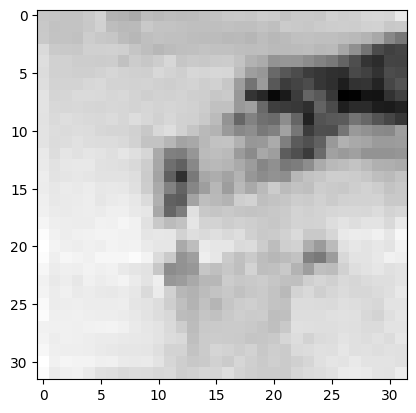